# Kepler.gl and NetworkX fun with airports and airline routes data

## Step 1: Import data set from Openflights.org ## 

In [2]:
import pandas as pd
import json
import pprint
import networkx as nx
from pyvis.network import Network
import numpy as np


routes_header = ['airline', 'airline ID','source airport','source airport ID','destination airport','destination airport ID', 'code share', 'stops','equipment']
airports_header = ['id','source airport', 'city','country','source code1','source code2', 'lattitude','longitude','number1','number2','letter','region', 'airport2','airport3']

routes = pd.read_csv("../data/routes.dat",header=None,names=routes_header,skiprows=1)
airports = pd.read_csv("../data/airports.csv",header=None,names=airports_header,skiprows=1)

## Step 2: Exploration - What does our data look like? ##

In [2]:
routes.head()


,airline,airline ID,source airport,source airport ID,destination airport,destination airport ID,code share,stops,equipment
0,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
2,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
3,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
4,2B,410,DME,4029,KZN,2990,NaN,0,CR2


In [3]:
airports.head()


,id,source airport,city,country,source code1,source code2,lattitude,longitude,number1,number2,letter,region,airport2,airport3
0,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
1,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
2,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
3,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
4,6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby,airport,OurAirports


## Step 3: Research questions?

- What Caribbean airports are connected to each other?

- What are the most central Caribbean airports?


## Step 4: Wrangling

In order to answer these questions we need to tidy the data to see the following:

- For each airport, store the location as a tuple of coordinates

- For each airport, list the destinations

#### 4.1 Create list of destinations for each airport

In [4]:
routes = routes.groupby('source airport')['destination airport'].apply(lambda x: list(x)).reset_index()

#### 4.2 Create a tuple of coordinates for each airport ###


In [5]:
airports = airports[['source airport', 'city', 'country', 'source code1', 'lattitude', 'longitude']]

In [6]:
airports['location'] = list(zip(airports['longitude'],airports['lattitude']))

In [7]:
airports.head()

,source airport,city,country,source code1,lattitude,longitude,location
0,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001,"(145.789001465, -5.20707988739)"
1,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005,"(144.29600524902344, -5.826789855957031)"
2,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977,"(146.725977, -6.569803)"
3,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001,"(147.22000122070312, -9.443380355834961)"
4,Wewak International Airport,Wewak,Papua New Guinea,WWK,-3.583830,143.669006,"(143.66900634799998, -3.5838301181800003)"


#### 4.3 Merge tables and tidy data

In [8]:
routes = pd.merge(left = routes, right = airports, how = 'inner', left_on = 'source airport', right_on = 'source code1')

In [9]:
routes = routes.rename(columns = {'source airport_x': 'airport_code', 'source airport_y': 'airport_name',
                         'destination airport':'destination_airport'})

In [10]:
# routes = routes.drop(columns = ['source code1', 'lattitude', 'longitude'])
routes = routes.drop(columns = ['source code1'])

In [11]:
routes.head()

,airport_code,destination_airport,airport_name,city,country,lattitude,longitude,location
0,AAE,"[ALG, CDG, IST, LYS, MRS, ORN, ORY, MRS, ORY]",Annaba Airport,Annaba,Algeria,36.822201,7.809170,"(7.8091697692871085, 36.82220077514648)"
1,AAL,"[AMS, AAR, OSL, BLL, SVG, AGP, ALC, CPH, LGW, ...",Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,"(9.84924316406, 57.092758913800004)"
2,AAN,"[CCJ, PEW]",Al Ain International Airport,Al Ain,United Arab Emirates,24.261700,55.609200,"(55.60919952392578, 24.261699676513672)"
3,AAQ,"[DME, LED, SVO]",Anapa Vityazevo Airport,Anapa,Russia,45.002102,37.347301,"(37.347301483154, 45.002101898193)"
4,AAR,"[AAL, BMA, GOT, OSL, AGP, PMI, STN, CPH]",Aarhus Airport,Aarhus,Denmark,56.299999,10.619000,"(10.619000434899998, 56.2999992371)"


## Step 5: Write NetworkX graphing functions

In [12]:
draw_params = {"node_color" : "pink", "font_size" : 10, "with_labels" : True, "arrowsize" : 20}


In [13]:
def locater(airport, roster=routes):
    """
        Finds airport location
        
        Parameters
        ----------
        roster : a pandas dataframe with 3 columns of interest:
            - airport_code
            - list of destination airports
            - coordinate location of airport
        
        airport : a string representing an airport code
        
        Returns
        -------
        tuple of coordinates (longitude, lattitude)

        Examples
        --------
        locater('BGI') --> (13.0746002197, -59.492500305200004)
        locater('YYZ') --> (43.6772003174, -79.63059997559999)
    """       
    return roster[roster['airport_code']== airport]['location'].values[0]

In [14]:
locater('YYZ')

(-79.63059997559999, 43.6772003174)

In [15]:
def route_mapper(roster, airport):
    """
        Creates a dictionary roster of destinations for each location.
        
        Parameters
        ----------
        roster : a pandas dataframe with 3 columns of interest:
            - airport_code
            - list of destination airports
            - coordinate location of airport
        
        airport : a string representing an airport code
        
        Returns
        -------
        graph

        Examples
        --------
        route_mapper(routes)
    """       
    G = nx.Graph()
    G.add_node(airport, pos = locater(airport, roster))
    list(map(lambda x: G.add_node(x, pos = locater(x, roster)), list(roster[roster['airport_code'] == airport]['destination_airport'])[0]))
    list(map(lambda x: G.add_edge(airport,x),list(roster[roster['airport_code'] == airport]['destination_airport'])[0]))
    return G

In [16]:
Barbados = route_mapper(routes, 'BGI')

In [17]:
pos = nx.get_node_attributes(Barbados,'pos')

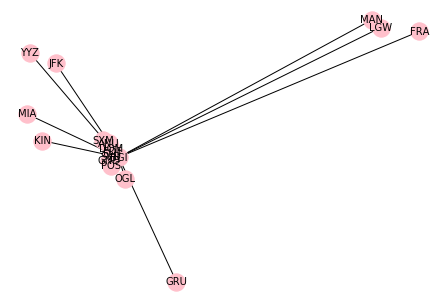

In [19]:
nx.draw(Barbados, pos, **draw_params)

In [20]:
pos

{'BGI': (-59.492500305200004, 13.0746002197),
 'MIA': (-80.29060363769531, 25.79319953918457),
 'YYZ': (-79.63059997559999, 43.6772003174),
 'JFK': (-73.77890015, 40.63980103),
 'LGW': (-0.19027799367904666, 51.14810180664063),
 'ANU': (-61.792702, 17.1367),
 'KIN': (-76.7874984741211, 17.935699462890625),
 'POS': (-61.33720016479492, 10.595399856567383),
 'SXM': (-63.108898162799996, 18.0410003662),
 'FRA': (8.5705556, 50.033333299999995),
 'MAN': (-2.2749500274658203, 53.35369873046875),
 'GRU': (-46.47305679321289, -23.435556411743164),
 'DOM': (-61.29999923706055, 15.54699993133545),
 'FDF': (-61.00320053100586, 14.590999603271484),
 'GND': (-61.78620147705078, 12.004199981689453),
 'OGL': (-58.1058998108, 6.80628013611),
 'SLU': (-60.992901, 14.0202),
 'SVD': (-61.210899353027344, 13.14430046081543)}

In [21]:
routes.head()

,airport_code,destination_airport,airport_name,city,country,lattitude,longitude,location
0,AAE,"[ALG, CDG, IST, LYS, MRS, ORN, ORY, MRS, ORY]",Annaba Airport,Annaba,Algeria,36.822201,7.809170,"(7.8091697692871085, 36.82220077514648)"
1,AAL,"[AMS, AAR, OSL, BLL, SVG, AGP, ALC, CPH, LGW, ...",Aalborg Airport,Aalborg,Denmark,57.092759,9.849243,"(9.84924316406, 57.092758913800004)"
2,AAN,"[CCJ, PEW]",Al Ain International Airport,Al Ain,United Arab Emirates,24.261700,55.609200,"(55.60919952392578, 24.261699676513672)"
3,AAQ,"[DME, LED, SVO]",Anapa Vityazevo Airport,Anapa,Russia,45.002102,37.347301,"(37.347301483154, 45.002101898193)"
4,AAR,"[AAL, BMA, GOT, OSL, AGP, PMI, STN, CPH]",Aarhus Airport,Aarhus,Denmark,56.299999,10.619000,"(10.619000434899998, 56.2999992371)"


In [22]:
net = Network()

In [23]:
G2 = Network()
G2.from_nx(Barbados)

In [24]:
G2.show("nxport.html")

In [295]:
def initialize_map(roster, airport):
    """
        Creates a dictionary roster of destinations for each location.
        
        Parameters
        ----------
        roster : a pandas dataframe with 3 columns of interest:
            - airport_code
            - list of destination airports
            - coordinate location of airport
        
        airport : a string representing an airport code
        
        Returns
        -------
        graph

        Examples
        --------
        route_mapper(routes)
    """       
    G = Network()
    x, y = locater(airport, routes)
    G.add_node(0, node = airport, label = routes.query('airport_code == @airport')['country'].item(),
               title = routes.query('airport_code == @airport')['airport_name'].item(),
               x = x, y = y)
    
    
    airport_neighbours = list(set(list(routes.query("airport_code == @airport")['destination_airport'])[0]))
    
    G.add_nodes(list(range(1,len(airport_neighbours)+1)),
    #            nodes = airport_neighbours,
                title = list(routes.query('airport_code in @airport_neighbours')['airport_name']),                
                label = list(routes.query('airport_code in @airport_neighbours')['country']),
                x = list(routes.query('airport_code in @airport_neighbours')['longitude']),
                y = list(routes.query('airport_code in @airport_neighbours')['lattitude']))

    G.show('just_nodes.html')
    
    for i in range(1,len(airport_neighbours)+1):
    
        G.add_edge(0, i)
    

    G.show('with_edges.html')

    for n in G.nodes:
        n.update({'physics': False})

    G.show('with_edges_and_physics.html')




In [282]:
def add_neighbours(G, roster, airport):
    """
        Creates a dictionary roster of destinations for each location.
        
        Parameters
        ----------
        roster : a pandas dataframe with 3 columns of interest:
            - airport_code
            - list of destination airports
            - coordinate location of airport
        
        airport : a string representing an airport code
        
        Returns
        -------
        graph

        Examples
        --------
        route_mapper(routes)
    """       
    airport_neighbours = list(set(list(routes.query("airport_code == @airport")['destination_airport'])[0]))
    
    G.add_nodes(list(range(1,len(airport_neighbours)+1)),
    #            nodes = airport_neighbours,
                title = list(routes.query('airport_code in @airport_neighbours')['airport_name']),                
                label = list(routes.query('airport_code in @airport_neighbours')['country']),
                x = list(routes.query('airport_code in @airport_neighbours')['longitude']),
                y = list(routes.query('airport_code in @airport_neighbours')['lattitude']),
                physics = True)

    return G

In [296]:
initialize_map(routes, "BGI")



/Users/jaromeleslie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: `item` has been deprecated and will be removed in a future version
/Users/jaromeleslie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: `item` has been deprecated and will be removed in a future version


In [301]:


list(np.ones(17))

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [284]:
barbados = add_neighbours(barbados, routes, "BGI")

AssertionError: invalid arg 'physics'

In [285]:
toggle_physics() 

NameError: name 'toggle_physics' is not defined

In [201]:
locater("BGI", routes)

(-59.492500305200004, 13.0746002197)

In [211]:
 G = Network()
   

In [215]:
x, y = locater("BGI", routes)
x, y

(-59.492500305200004, 13.0746002197)

In [221]:
G.add_node(0, node = "BGI", x = x, y = y, label = str(routes.query('airport_code == "BGI"')['country']))

In [250]:
routes.query('airport_code == "BGI"')['country'].item()

/Users/jaromeleslie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `item` has been deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


'Barbados'

In [130]:
BGI_neighbours = list(set(list(routes.query("airport_code == 'BGI'")['destination_airport'])[0]))

In [131]:
len(BGI_neighbours)

17

In [184]:
float(routes.query('airport_code == "BGI"')['longitude'])

-59.492500305200004

In [164]:
# routes.loc['BGI']

In [104]:
len(list(routes.query('airport_code in @BGI_neighbours')['airport_name']))

17

In [106]:
routes.query('airport_code in @BGI_neighbours')

,airport_code,destination_airport,airport_name,city,country,lattitude,longitude,location
114,ANU,"[PTP, NEV, CLT, JFK, MIA, YYZ, LGW, PUJ, SKB, ...",V.C. Bird International Airport,Antigua,Antigua and Barbuda,17.136700,-61.792702,"(-61.792702, 17.1367)"
678,DOM,"[PTP, SXM, SJU, SJU, ANU, BGI, PTP, SJU, SVD, ...",Melville Hall Airport,Dominica,Dominica,15.547000,-61.299999,"(-61.29999923706055, 15.54699993133545)"
807,FDF,"[CAY, PTP, SDQ, SLU, MIA, SJU, YUL, CAY, ORY, ...",Martinique Aimé Césaire International Airport,Fort-de-france,Martinique,14.591000,-61.003201,"(-61.00320053100586, 14.590999603271484)"
841,FRA,"[HDF, KIV, ATH, HER, SKG, CLT, DFW, KUL, LHR, ...",Frankfurt am Main International Airport,Frankfurt,Germany,50.033333,8.570556,"(8.5705556, 50.033333299999995)"
924,GND,"[MIA, YYZ, UVF, JFK, POS, YYZ, JFK, BGI, POS, ...",Point Salines International Airport,Point Salines,Grenada,12.004200,-61.786201,"(-61.78620147705078, 12.004199981689453)"
951,GRU,"[CAC, DOU, RAO, UBA, UDI, VDC, MVD, CLT, DFW, ...",Guarulhos - Governador André Franco Montoro In...,Sao Paulo,Brazil,-23.435556,-46.473057,"(-46.47305679321289, -23.435556411743164)"
1219,JFK,"[EZE, MEX, MSY, AMM, ANU, AUH, AUS, BCN, BDA, ...",John F Kennedy International Airport,New York,United States,40.639801,-73.778900,"(-73.77890015, 40.63980103)"
1330,KIN,"[CUR, MIA, YYZ, FLL, JFK, LGW, ANU, BGI, FLL, ...",Norman Manley International Airport,Kingston,Jamaica,17.935699,-76.787498,"(-76.7874984741211, 17.935699462890625)"
1506,LGW,"[FNA, CMN, TNG, LAS, MCO, TPA, SZG, CTA, PMO, ...",London Gatwick Airport,London,United Kingdom,51.148102,-0.190278,"(-0.19027799367904666, 51.14810180664063)"
1623,MAN,"[CGN, HAM, ATH, HEL, JFK, LHR, ORD, PHL, ATL, ...",Manchester Airport,Manchester,United Kingdom,53.353699,-2.274950,"(-2.2749500274658203, 53.35369873046875)"


In [147]:
BGI2

<class 'pyvis.network.Network'> |N|=18 |E|=0

In [148]:
#BGI.enable_physics(True)
BGI2.show("mymap2.html")


In [293]:
#barbados.enable_physics(True)
barbados.show("test.html")

